# Reproject the ESA-CCI land cover map for Europe

In [1]:
from xcube.core.store import new_data_store
from xcube_resampling.spatial import resample_in_space
from xcube_resampling.gridmapping import GridMapping
from datetime import datetime
import matplotlib.pyplot as plt
import pyproj
import numpy as np

We use the ESA CCI Land Cover map available from the [DeepESDL](https://www.earthsystemdatalab.net/) public S3 bucket. In the following cell, we access the multi-resolution dataset `"LC-1x2025x2025-2.0.0.levels"` and select the base level, which corresponds to the original spatial resolution of approximately 300 meters.

In [2]:
%%time
store = new_data_store("s3", root="deep-esdl-public")
mlds_lc = store.open_data("LC-1x2025x2025-2.0.0.levels")
ds = mlds_lc.base_dataset
ds_time_slice = ds.sel(time=datetime(2022, 1, 1))
ds

CPU times: user 209 ms, sys: 38.3 ms, total: 247 ms
Wall time: 1.01 s


<xarray.Dataset> Size: 3TB
Dimensions:              (time: 31, lat: 64800, lon: 129600, bounds: 2)
Coordinates:
  * lat                  (lat) float64 518kB 90.0 90.0 89.99 ... -90.0 -90.0
  * lon                  (lon) float64 1MB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time                 (time) datetime64[ns] 248B 1992-01-01 ... 2022-01-01
Dimensions without coordinates: bounds
Data variables:
    change_count         (time, lat, lon) uint8 260GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    crs                  int32 4B ...
    current_pixel_state  (time, lat, lon) float32 1TB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    lat_bounds           (lat, bounds) float64 1MB dask.array<chunksize=(2025, 2), meta=np.ndarray>
    lccs_class           (time, lat, lon) uint8 260GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    lon_bounds           (lon, bounds) float64 2MB dask.array<chunksize=(2025, 2), meta=np.ndarray>
    observation_count    (time, lat, lon) uint16 521GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    processed_flag       (time, lat, lon) float32 1TB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    time_bounds          (time, bounds) datetime64[ns] 496B dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

We generate a regular grid mapping covering Germany and demonstrate that the new `reproject_dataset` method produces results very similar to those of the `resample_in_space` method. 

As a first step, we create a regular grid mapping using the EPSG:3035 coordinate reference system.

In [3]:
%%time
bbox = [5, 46, 15, 57]
target_crs = "EPSG:3035"
t = pyproj.Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)
target_bbox = t.transform_bounds(*bbox)
spatial_res = 150
x_size = int((target_bbox[2] - target_bbox[0]) / spatial_res) + 1
y_size = int(abs(target_bbox[3] - target_bbox[1]) / spatial_res) + 1
target_gm = GridMapping.regular(
    size=(x_size, y_size),
    xy_min=(target_bbox[0] - spatial_res / 2, target_bbox[1] - spatial_res / 2),
    xy_res=spatial_res,
    crs=target_crs,
    tile_size=4000,
)

CPU times: user 28.8 ms, sys: 4.97 ms, total: 33.8 ms
Wall time: 32.9 ms


Firstly, we apply the exsisting `resample_in_space` method, where we clip the source dataset. Otherwise, `resampling_in_space` would take for ever. 

In [4]:
%%time
ds_resampling = resample_in_space(ds_time_slice, target_gm=target_gm)
ds_resampling

CPU times: user 8.73 s, sys: 186 ms, total: 8.92 s
Wall time: 8.92 s


<xarray.Dataset> Size: 510MB
Dimensions:              (x: 5167, y: 8227, bounds: 2)
Coordinates:
  * x                    (x) float64 41kB 3.934e+06 3.934e+06 ... 4.708e+06
  * y                    (y) float64 66kB 3.777e+06 3.777e+06 ... 2.543e+06
    spatial_ref          int64 8B 0
    time                 datetime64[ns] 8B 2022-01-01
Dimensions without coordinates: bounds
Data variables:
    change_count         (y, x) uint8 43MB dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    current_pixel_state  (y, x) float32 170MB dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    lccs_class           (y, x) uint8 43MB dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    observation_count    (y, x) uint16 85MB dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    processed_flag       (y, x) float32 170MB dask.array<chunksize=(4000, 4000), meta=np.ndarray>
    time_bounds          (bounds) datetime64[ns] 16B dask.array<chunksize=(2,), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

CPU times: user 6.64 s, sys: 698 ms, total: 7.34 s
Wall time: 3.64 s


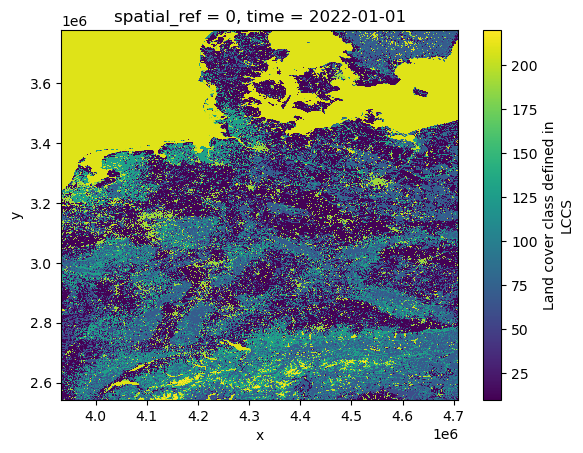

In [5]:
%%time
ds_resampling.lccs_class[::5, ::5].plot()

The `reproject_dataset` method can handle source datasets of any size. It automatically selects the overlapping portions of the source dataset that intersect with the target grid mapping.

If the extent of the source dataset is too small and the target grid mapping extends beyond its boundaries, padding with a fill value is required. This fill value can either be provided by the user or is determined by the data type of the data array, as described in the docstring of the `reproject_dataset` method.

In [6]:
%%time
ds = ds.sel(time=slice(datetime(2018, 1, 1), datetime(2022, 1, 1)))
ds = ds[["lccs_class"]]
ds

CPU times: user 57.5 ms, sys: 11 ms, total: 68.5 ms
Wall time: 67.4 ms


<xarray.Dataset> Size: 42GB
Dimensions:     (time: 5, lat: 64800, lon: 129600)
Coordinates:
  * lat         (lat) float64 518kB 90.0 90.0 89.99 89.99 ... -89.99 -90.0 -90.0
  * lon         (lon) float64 1MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time        (time) datetime64[ns] 40B 2018-01-01 2019-01-01 ... 2022-01-01
Data variables:
    lccs_class  (time, lat, lon) uint8 42GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

In [9]:
%%time
bbox = [-20, 25, 40, 85]
target_crs = "EPSG:3035"
t = pyproj.Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)
target_bbox = t.transform_bounds(*bbox)
spatial_res = 300
x_size = int((target_bbox[2] - target_bbox[0]) / spatial_res) + 1
y_size = int(abs(target_bbox[3] - target_bbox[1]) / spatial_res) + 1
target_gm = GridMapping.regular(
    size=(x_size, y_size),
    xy_min=(target_bbox[0] - spatial_res / 2, target_bbox[1] - spatial_res / 2),
    xy_res=spatial_res,
    crs=target_crs,
    tile_size=4000,
)
target_gm

CPU times: user 18.5 ms, sys: 2.98 ms, total: 21.5 ms
Wall time: 20.5 ms


class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: EPSG:3035
* xy_res: (300, 300)
* xy_bbox: (1287527, 239402, 7354427, 6906902)
* ij_bbox: (0, 0, 20223, 22225)
* xy_dim_names: ('x', 'y')
* xy_var_names: ('x', 'y')
* size: (20223, 22225)
* tile_size: (4000, 4000)

In [8]:
%%time
ds_reproject = resample_in_space(ds, target_gm=target_gm)
ds_reproject

CPU times: user 1min 49s, sys: 71.5 ms, total: 1min 49s
Wall time: 1min 49s


KeyboardInterrupt: 

In [ ]:
%%time
ds_reproject.lccs_class.isel(time=-1)[::20, ::20].plot()

In [ ]:
%%time
ds_clip = ds.sel(lon=slice(-20, 40), lat=slice(85, 25))
ds_clip_reproject = reproject_dataset(ds_clip, target_gm=target_gm)
ds_clip_reproject

In [ ]:
%%time
ds_clip_reproject.lccs_class.isel(time=-1)[::20, ::20].plot()